In [1]:
% run 0-utils.ipynb

In [2]:
% run 4-graph-utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from gcnn.datasets import load_icebergs

In [4]:
icebergs = load_icebergs('train')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from tensorboardX import SummaryWriter
import skimage.transform as transform
import skimage.filters as filters
import networkx as nx
from scipy import spatial
import scipy.sparse.csgraph

In [5]:
icebergs.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [6]:
gr_size = 38
gr = grid(gr_size)
gr.shape

(1444, 2)

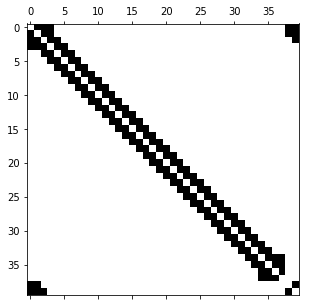

In [7]:
mask = distance(gr, k=6, metric='cityblock') > 0
plt.spy(mask[:40, :40]);

In [8]:
graphs, perm = coarsen(sp.sparse.csr.csr_matrix(mask), levels=3, self_connections=False)

Layer 0: M_0 = |V| = 1568 nodes (124 added),|E| = 8302 edges
Layer 1: M_1 = |V| = 784 nodes (36 added),|E| = 4382 edges
Layer 2: M_2 = |V| = 392 nodes (7 added),|E| = 2202 edges
Layer 3: M_3 = |V| = 196 nodes (0 added),|E| = 1100 edges


In [9]:
len(perm)

1568

In [10]:
laps = [sp.sparse.csgraph.laplacian(g, normed=True) for g in graphs[:-1]]

In [11]:
n = laps[0].shape[0]
n

1568

In [12]:
icebergs = icebergs.assign(
    graph=icebergs
        .band_1
        .apply(lambda x: transform.rescale(x.reshape(75, 75), 0.5, mode='constant'))
        .apply(lambda x: filters.gaussian(x, 2))
        .apply(lambda x: np.r_[x[tuple(gr.reshape(2, -1))], np.zeros(n - gr_size * gr_size)][perm])
)

In [13]:
train, test = train_test_split(icebergs, test_size=0.15, stratify=icebergs.is_iceberg)
np.unique(train.is_iceberg, return_counts=True)[1] / len(train)

array([ 0.53044754,  0.46955246])

In [14]:
np.unique(test.is_iceberg, return_counts=True)[1] / len(test)

array([ 0.53112033,  0.46887967])

In [15]:
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_graph = StandardScaler()

In [16]:
for _, i in train.iterrows():
    scaler_1.partial_fit(i.band_1.reshape(1, -1))
    scaler_2.partial_fit(i.band_2.reshape(1, -1))
    scaler_graph.partial_fit(i.graph.reshape(1, -1))

In [17]:
train_x = torch.from_numpy(scaler_graph.transform(np.stack(train.graph))).float()
test_x = torch.from_numpy(scaler_graph.transform(np.stack(test.graph))).float()
train_y = torch.from_numpy(train.is_iceberg.values.reshape(-1, 1)).float()
test_y = torch.from_numpy(test.is_iceberg.values.reshape(-1, 1)).float()

In [18]:
def fourier(laplacian):
    eigenvalues, eigenvectors = sp.linalg.eigh(laplacian)
    return eigenvectors

In [19]:
f0 = torch.from_numpy(fourier(laps[0].todense())).float()
f0.size()

torch.Size([1568, 1568])

In [20]:
f1 = torch.from_numpy(fourier(laps[1].todense())).float()
f1.size()

torch.Size([784, 784])

In [21]:
f2 = torch.from_numpy(fourier(laps[2].todense())).float()
f2.size()

torch.Size([392, 392])

In [22]:
cuda = torch.cuda.is_available()
num_epochs = 250
batch_size = 64
learning_rate = 0.000001
cuda

True

In [23]:
train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=True)

In [24]:
class GraphConv(nn.Module):
    def __init__(self, fourier, n_filter):
        super(GraphConv, self).__init__()
        
        self.n = len(fourier)
        self.u = Variable(fourier, requires_grad=False)
        self.n_filter = n_filter
        
        self.weight = nn.Parameter(torch.Tensor(self.n, self.n_filter))
        self.bias = nn.Parameter(torch.Tensor(self.n))
        
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x): # samples x n
        # fourier
        out = x @ self.u # samples x n
        
        # filter
        w = self.weight.unsqueeze(2) # n x f x 1
        out = out.t().unsqueeze(1) # n x 1 x samples
        out = w @ out # n x f x samples
        
        # un-fourier
        out = out.permute(2, 1, 0).contiguous() # samples x f x n
        out = out.view(-1, self.n) # (samples * f) x n
        out = out @ self.u.t() # (samples * f) x n
        out = out.view(-1, self.n_filter, self.n) # samples x f x n
        
        # bias?
        out = out + self.bias # samples x f x n
        return out

In [25]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)        

In [26]:
class GraphFourierConv(nn.Module):
    def __init__(self, fourier_basis, in_channels, out_channels, bias=True):
        super().__init__()
 
        self.n = fourier_basis.size(0)
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        assert fourier_basis.size(1) == self.n
        self.u = Variable(fourier_basis, requires_grad=False) # n x n
        self.ut = self.u.t()

        self.weight = nn.Parameter(torch.Tensor(self.n, self.out_channels, 1)) # n x out x 1
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_channels, 1))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        # batch x in x n

        # fourier
        out = x.view(-1, self.n) # (batch * in) x n
        out = out @ self.u # (batch * in) x n
        
        # filter
        out = out.t().unsqueeze(1) # n x 1 x (batch * in)
        out = self.weight @ out # n x out x (batch * in)

        # un-fourier
        out = out.transpose(0, 2).contiguous() # (batch * in) x out x n
        out = out.view(-1, self.n) # (batch * in * out) x n
        out = out @ self.ut # (batch * in * out) x n
        out = out.view(-1, self.in_channels, self.out_channels, self.n) # batch x in x out x n
        
        # sum in dim + bias
        out = out.sum(1) # batch x out x n
        if self.bias is not None:
            out = out + self.bias # batch x out x n
        
        return out
    
    def __repr__(self):
        return '{}(fourier_basis, {}, {}, bias={})'.format(__class__.__name__, self.in_channels, self.out_channels, self.bias)

In [27]:
conv1_dim = 16
conv2_dim = 16

class Net(nn.Module):
    def __init__(self,conv1_dim=16,conv2_dim=16):
        super().__init__()
        self.layer1 = nn.Sequential(
        #GraphConv(f.cuda() if cuda else f, conv1_dim),
        GraphFourierConv(f0.cuda() if cuda else f, 1, conv1_dim, bias=False),
        nn.BatchNorm2d(conv1_dim),
        nn.ReLU(),
        nn.MaxPool1d(2),

        GraphFourierConv(f1.cuda() if cuda else f, conv1_dim, conv2_dim, bias=False),
        nn.BatchNorm2d(conv2_dim),
        nn.ReLU(),
        nn.MaxPool1d(2),

        Flatten(),
        nn.Linear(len(f1) // 2 * conv2_dim, 600),
        nn.ReLU(),
        nn.Linear(600, 200),
        nn.ReLU(),
        nn.Linear(200, 1),
        )
    def forward(self,x):
        out = self.layer1(x)
        return out

net = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
writer = SummaryWriter()

if cuda:
    net.cuda()
    criterion.cuda()

writer.add_graph(net, net(Variable(train_x.narrow(0, 0, 1)).cuda()))

epoch_train_loss = []
epoch_test_loss = []

In [ ]:
#redifining scoring for sklearn 
from skorch import NeuralNet
from skorch.utils import to_numpy
class NNplusplus(NeuralNet):
    def score(self,X,target):
        y_preds = []
        for yp in self.forward_iter(X, training=False):
            y_preds.append(to_numpy(yp.sigmoid()))
       
        y_preds = np.concatenate(y_preds, 0)
   
        return log_loss(target,y_preds)

In [30]:
model = NNplusplus(
    Net,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, #regularization
    max_epochs=250,
    batch_size=25,
    lr=0.000001,
    use_cuda = True
)

In [31]:
#tuning part 
import scipy.stats as sc
param_dis = {
    'batch_size': [32,64],
    'module__conv1_dim':[16,32,64],
    'module__conv2_dim':[16,32,64],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
gsR = RandomizedSearchCV(model, param_dis, refit=False,n_jobs=1,n_iter=5)

In [ ]:
gsR.fit(train_x.numpy(),train_y.numpy())

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7039        0.6985  5.0120
      2        0.6950        0.7004  5.0339
      3        0.6882        0.6998  4.7786
      4        0.6825        0.6952  4.7422
      5        0.6778        0.6876  4.7911
      6        0.6739        0.6815  4.7670
      7        0.6705        0.6778  4.7734
      8        0.6677        0.6753  4.8773
      9        0.6652        0.6736  4.8088
     10        0.6630        0.6722  5.0128
     11        0.6611        0.6710  4.8411
     12        0.6594        0.6699  4.8122
     13        0.6579        0.6690  4.7792
     14        0.6566        0.6682  4.7885
     15        0.6555        0.6674  4.8077
     16        0.6545        0.6667  4.8354
     17        0.6535        0.6661  4.7910
     18        0.6527        0.6655  4.7924
     19        0.6519        0.6649  4.7899
     20        0.6512        0.6643  4.8060
     21        0.6505        0.6

    133        0.6042        0.6149  4.9536
    134        0.6038        0.6146  4.8935
    135        0.6034        0.6142  4.8432
    136        0.6030        0.6139  4.8171
    137        0.6026        0.6136  4.7767
    138        0.6022        0.6133  4.7763
    139        0.6018        0.6129  4.7999
    140        0.6014        0.6126  4.7824
    141        0.6010        0.6123  4.9051
    142        0.6006        0.6120  4.7760
    143        0.6002        0.6117  4.8571
    144        0.5998        0.6114  4.8846
    145        0.5995        0.6111  4.8542
    146        0.5991        0.6108  4.8239
    147        0.5987        0.6105  4.7456
    148        0.5983        0.6102  4.7816
    149        0.5979        0.6099  4.7550
    150        0.5975        0.6096  4.8556
    151        0.5972        0.6093  4.7466
    152        0.5968        0.6090  4.8156
    153        0.5964        0.6087  4.8022
    154        0.5960        0.6084  4.8859
    155        0.5956        0.6

     14        0.6511        0.6538  4.8472
     15        0.6501        0.6530  4.7512
     16        0.6492        0.6523  4.8231
     17        0.6484        0.6517  4.7918
     18        0.6476        0.6510  4.9110
     19        0.6469        0.6505  4.8265
     20        0.6463        0.6500  4.7904
     21        0.6457        0.6495  4.8899
     22        0.6451        0.6491  4.9445
     23        0.6445        0.6487  4.8304
     24        0.6440        0.6483  4.8657
     25        0.6435        0.6479  4.8873
     26        0.6430        0.6476  4.8456
     27        0.6426        0.6472  4.8287
     28        0.6421        0.6468  4.8312
     29        0.6416        0.6465  4.8406
     30        0.6412        0.6461  4.8621
     31        0.6407        0.6458  4.8218
     32        0.6403        0.6454  4.9699
     33        0.6398        0.6451  4.8640
     34        0.6394        0.6448  4.8939
     35        0.6390        0.6445  4.9338
     36        0.6385        0.6

    147        0.5976        0.6172  4.7711
    148        0.5973        0.6170  4.8425
    149        0.5970        0.6168  4.8136
    150        0.5966        0.6166  4.7568
    151        0.5963        0.6165  4.7820
    152        0.5960        0.6163  4.8775
    153        0.5957        0.6161  4.8398
    154        0.5954        0.6159  4.8066
    155        0.5950        0.6157  4.8526
    156        0.5947        0.6156  4.8774
    157        0.5944        0.6154  4.7705
    158        0.5941        0.6152  4.8314
    159        0.5938        0.6150  4.7796
    160        0.5935        0.6149  4.8452
    161        0.5932        0.6147  4.7523
    162        0.5929        0.6145  4.8193
    163        0.5926        0.6143  4.7901
    164        0.5923        0.6141  4.8104
    165        0.5919        0.6140  4.8771
    166        0.5916        0.6138  4.7668
    167        0.5913        0.6136  4.8155
    168        0.5910        0.6135  4.7748
    169        0.5907        0.6

     28        0.6422        0.6484  4.9561
     29        0.6416        0.6480  4.7997
     30        0.6410        0.6476  4.8232
     31        0.6405        0.6472  4.9894
     32        0.6399        0.6469  4.8252
     33        0.6394        0.6465  4.9302
     34        0.6388        0.6461  4.7842
     35        0.6383        0.6458  4.8648
     36        0.6378        0.6454  4.7932
     37        0.6373        0.6450  4.7774
     38        0.6367        0.6447  4.7615
     39        0.6362        0.6443  4.8433
     40        0.6357        0.6439  4.9039
     41        0.6351        0.6435  4.7844
     42        0.6346        0.6431  4.8422
     43        0.6341        0.6428  4.7489
     44        0.6336        0.6424  4.7774
     45        0.6330        0.6421  4.8536
     46        0.6325        0.6417  4.8633
     47        0.6320        0.6414  4.8723
     48        0.6315        0.6410  4.8078
     49        0.6309        0.6407  4.8500
     50        0.6304        0.6

    161        0.5813        0.6061  4.7656
    162        0.5809        0.6058  4.7524
    163        0.5806        0.6056  4.9143
    164        0.5802        0.6053  4.7519
    165        0.5798        0.6051  4.9731
    166        0.5794        0.6048  4.8066
    167        0.5791        0.6046  4.7973
    168        0.5787        0.6043  4.8571
    169        0.5783        0.6041  4.8125
    170        0.5779        0.6038  4.7642
    171        0.5776        0.6036  4.8354
    172        0.5772        0.6033  4.7818
    173        0.5768        0.6031  4.8218
    174        0.5764        0.6028  4.9011
    175        0.5761        0.6026  4.8551
    176        0.5757        0.6024  4.8180
    177        0.5753        0.6021  4.8602
    178        0.5750        0.6019  4.5743
    179        0.5746        0.6016  4.7708
    180        0.5743        0.6014  4.8786
    181        0.5739        0.6011  4.8200
    182        0.5735        0.6009  4.8081
    183        0.5732        0.6

     42        0.6603        0.6730  2.5201
     43        0.6601        0.6728  2.5205
     44        0.6599        0.6727  2.5260
     45        0.6598        0.6725  2.5342
     46        0.6596        0.6724  2.4488
     47        0.6594        0.6722  2.5048
     48        0.6593        0.6720  2.6039
     49        0.6591        0.6719  2.3997
     50        0.6589        0.6717  2.5885
     51        0.6587        0.6715  2.6007
     52        0.6586        0.6714  2.4780
     53        0.6584        0.6712  2.4998
     54        0.6582        0.6710  2.5438
     55        0.6581        0.6709  2.5302
     56        0.6579        0.6707  2.5302
     57        0.6577        0.6705  2.5173
     58        0.6576        0.6704  2.5482
     59        0.6574        0.6702  2.6382
     60        0.6572        0.6700  2.5479
     61        0.6571        0.6698  2.6153
     62        0.6569        0.6697  2.5673
     63        0.6567        0.6695  2.5857
     64        0.6566        0.6

    175        0.6334        0.6437  2.5631
    176        0.6332        0.6434  2.6144
    177        0.6330        0.6431  2.3900
    178        0.6327        0.6429  2.5765
    179        0.6325        0.6426  2.5413
    180        0.6322        0.6423  2.4307
    181        0.6320        0.6421  2.4946
    182        0.6317        0.6418  2.4710
    183        0.6315        0.6415  2.4974
    184        0.6312        0.6412  2.3934
    185        0.6310        0.6410  2.5076
    186        0.6308        0.6407  2.5549
    187        0.6305        0.6405  2.3801
    188        0.6303        0.6402  2.5260
    189        0.6300        0.6399  2.5949
    190        0.6298        0.6397  2.5449
    191        0.6295        0.6394  2.4090
    192        0.6293        0.6392  2.5662
    193        0.6290        0.6389  2.5453
    194        0.6288        0.6386  2.4954
    195        0.6285        0.6384  2.5718
    196        0.6282        0.6381  2.5661
    197        0.6280        0.6

     57        0.6393        0.6473  2.5638
     58        0.6390        0.6471  2.5222
     59        0.6388        0.6469  2.6600
     60        0.6385        0.6468  2.5510
     61        0.6382        0.6466  2.5490
     62        0.6380        0.6464  2.5725
     63        0.6377        0.6463  2.5439
     64        0.6374        0.6461  2.5733
     65        0.6372        0.6459  2.4384
     66        0.6369        0.6458  2.5365
     67        0.6367        0.6456  2.6237
     68        0.6364        0.6454  2.5597
     69        0.6362        0.6453  2.6084
     70        0.6359        0.6451  2.5710
     71        0.6357        0.6450  2.5751
     72        0.6354        0.6448  2.4669
     73        0.6352        0.6446  2.5607
     74        0.6349        0.6445  2.6049
     75        0.6347        0.6443  2.4745
     76        0.6344        0.6441  2.5485
     77        0.6341        0.6440  2.5476
     78        0.6339        0.6438  2.5188
     79        0.6336        0.6

    190        0.6098        0.6297  2.5583
    191        0.6096        0.6296  2.5981
    192        0.6095        0.6294  2.5315
    193        0.6093        0.6293  2.5763
    194        0.6091        0.6292  2.5170
    195        0.6089        0.6291  2.5711
    196        0.6087        0.6290  2.4637
    197        0.6085        0.6289  2.6566
    198        0.6083        0.6288  2.6681
    199        0.6081        0.6286  2.5444
    200        0.6079        0.6285  2.6491
    201        0.6077        0.6284  2.5633
    202        0.6075        0.6283  2.6049
    203        0.6073        0.6282  2.6124
    204        0.6072        0.6281  2.5573
    205        0.6070        0.6280  2.4043
    206        0.6068        0.6278  2.5214
    207        0.6066        0.6277  2.5531
    208        0.6064        0.6276  2.5288
    209        0.6062        0.6275  2.5155
    210        0.6060        0.6274  2.5421
    211        0.6058        0.6273  2.6238
    212        0.6057        0.6

     71        0.6422        0.6552  2.5557
     72        0.6418        0.6550  2.4630
     73        0.6415        0.6547  2.5253
     74        0.6412        0.6545  2.5953
     75        0.6408        0.6542  2.4854
     76        0.6405        0.6540  2.5444
     77        0.6402        0.6537  2.5638
     78        0.6398        0.6534  2.5187
     79        0.6395        0.6532  2.6929
     80        0.6391        0.6529  2.6146
     81        0.6388        0.6526  2.4741
     82        0.6384        0.6524  2.4290
     83        0.6381        0.6521  2.5488
     84        0.6377        0.6518  2.5715
     85        0.6374        0.6516  2.5695
     86        0.6371        0.6513  2.5319
     87        0.6367        0.6511  2.4935
     88        0.6364        0.6508  2.4270
     89        0.6360        0.6506  2.5163
     90        0.6357        0.6503  2.5743
     91        0.6354        0.6501  2.5196
     92        0.6350        0.6498  2.6357
     93        0.6347        0.6

    204        0.5953        0.6201  2.5219
    205        0.5950        0.6198  2.5413
    206        0.5946        0.6195  2.6227
    207        0.5942        0.6193  2.5073
    208        0.5939        0.6190  2.6104
    209        0.5935        0.6188  2.5016
    210        0.5932        0.6185  2.4579
    211        0.5928        0.6183  2.5140
    212        0.5924        0.6180  2.5912
    213        0.5921        0.6178  2.4930
    214        0.5917        0.6175  2.4548
    215        0.5914        0.6172  2.4720
    216        0.5910        0.6170  2.5882
    217        0.5907        0.6167  2.5156
    218        0.5903        0.6165  2.5993
    219        0.5900        0.6162  2.5439
    220        0.5896        0.6160  2.5484
    221        0.5893        0.6157  2.5143
    222        0.5889        0.6155  2.5767
    223        0.5886        0.6152  2.5040
    224        0.5882        0.6149  2.5558
    225        0.5879        0.6147  2.5278
    226        0.5875        0.6

     85        0.6288        0.6413  1.1538
     86        0.6285        0.6410  1.1912
     87        0.6282        0.6407  1.1962
     88        0.6279        0.6404  1.1941
     89        0.6276        0.6401  1.2114
     90        0.6273        0.6397  1.1971
     91        0.6270        0.6394  1.1944
     92        0.6267        0.6391  1.1941
     93        0.6264        0.6388  1.1938
     94        0.6260        0.6385  1.2002
     95        0.6257        0.6382  1.2018
     96        0.6254        0.6379  1.1949
     97        0.6251        0.6376  1.1931
     98        0.6248        0.6373  1.2420
     99        0.6245        0.6370  1.2528
    100        0.6241        0.6367  1.1858
    101        0.6238        0.6363  1.1828
    102        0.6235        0.6360  1.2089
    103        0.6232        0.6357  1.1840
    104        0.6229        0.6354  1.2078
    105        0.6226        0.6351  1.1936
    106        0.6223        0.6348  1.2067
    107        0.6220        0.6

    218        0.5862        0.6013  1.2294
    219        0.5859        0.6010  1.2178
    220        0.5856        0.6008  1.1944
    221        0.5852        0.6005  1.1537
    222        0.5849        0.6002  1.1970
    223        0.5846        0.6000  1.1960
    224        0.5843        0.5997  1.1885
    225        0.5840        0.5995  1.1756
    226        0.5836        0.5992  1.2869
    227        0.5833        0.5990  1.2621
    228        0.5830        0.5987  1.2456
    229        0.5827        0.5985  1.2230
    230        0.5824        0.5982  1.2040
    231        0.5820        0.5980  1.1939
    232        0.5817        0.5978  1.2022
    233        0.5814        0.5975  1.2220
    234        0.5811        0.5973  1.2747
    235        0.5808        0.5971  1.2418
    236        0.5804        0.5968  1.2030
    237        0.5801        0.5966  1.1974
    238        0.5798        0.5964  1.1978
    239        0.5795        0.5961  1.2023
    240        0.5792        0.5

     99        0.6391        0.6496  1.2545
    100        0.6388        0.6493  1.2510
    101        0.6386        0.6491  1.2120
    102        0.6383        0.6489  1.2666
    103        0.6380        0.6487  1.2076
    104        0.6378        0.6485  1.2190
    105        0.6375        0.6483  1.2397
    106        0.6372        0.6480  1.2134
    107        0.6370        0.6478  1.3599
    108        0.6367        0.6476  1.2767
    109        0.6364        0.6474  1.2165
    110        0.6362        0.6472  1.2362
    111        0.6359        0.6469  1.3296
    112        0.6356        0.6467  1.2128
    113        0.6353        0.6465  1.2512
    114        0.6351        0.6462  1.2029
    115        0.6348        0.6460  1.2537
    116        0.6345        0.6457  1.2488
    117        0.6342        0.6455  1.3146
    118        0.6339        0.6453  1.2676
    119        0.6336        0.6450  1.2652
    120        0.6334        0.6448  1.2486
    121        0.6331        0.6

    232        0.5988        0.6159  1.2849
    233        0.5985        0.6157  1.1979
    234        0.5982        0.6154  1.2307
    235        0.5979        0.6152  1.2300
    236        0.5976        0.6150  1.3295
    237        0.5973        0.6147  1.3079
    238        0.5970        0.6145  1.2286
    239        0.5968        0.6142  1.2565
    240        0.5965        0.6140  1.2652
    241        0.5962        0.6138  1.2091
    242        0.5959        0.6135  1.2065
    243        0.5956        0.6133  1.2478
    244        0.5953        0.6130  1.2625
    245        0.5950        0.6128  1.1971
    246        0.5947        0.6126  1.2645
    247        0.5944        0.6123  1.3137
    248        0.5941        0.6121  1.1999
    249        0.5938        0.6119  1.2571
    250        0.5935        0.6116  1.2236
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6891        0.6915  1.2113
      2        0.6855        0.6

    113        0.6048        0.6215  1.2029
    114        0.6044        0.6212  1.2568
    115        0.6040        0.6210  1.2097
    116        0.6037        0.6208  1.1991
    117        0.6033        0.6205  1.2467
    118        0.6029        0.6203  1.2696
    119        0.6026        0.6201  1.2215
    120        0.6022        0.6198  1.1871
    121        0.6018        0.6196  1.2307
    122        0.6014        0.6193  1.1979
    123        0.6011        0.6191  1.1553
    124        0.6007        0.6188  1.2401
    125        0.6003        0.6186  1.2201
    126        0.5999        0.6183  1.2596
    127        0.5996        0.6181  1.3351
    128        0.5992        0.6179  1.2567
    129        0.5988        0.6176  1.2032
    130        0.5985        0.6174  1.2520
    131        0.5981        0.6172  1.1900
    132        0.5977        0.6170  1.1881
    133        0.5974        0.6167  1.2107
    134        0.5970        0.6165  1.1993
    135        0.5967        0.6

    246        0.5586        0.5941  1.2287
    247        0.5583        0.5939  1.1752
    248        0.5580        0.5937  1.3068
    249        0.5577        0.5936  1.2088
    250        0.5574        0.5934  1.2520
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6837        0.7006  8.7789
      2        0.6675        0.6891  8.6830
      3        0.6591        0.6646  8.7196
      4        0.6544        0.6571  8.6845
      5        0.6516        0.6543  8.6644
      6        0.6495        0.6523  8.7299
      7        0.6479        0.6505  8.6180
      8        0.6465        0.6488  8.6521
      9        0.6452        0.6472  8.6737
     10        0.6440        0.6457  8.5167
     11        0.6428        0.6441  8.5908
     12        0.6416        0.6426  8.6571
     13        0.6404        0.6411  8.7201
     14        0.6393        0.6397  8.6387
     15        0.6383        0.6383  8.7718
     16        0.6372        0.6

    127        0.5448        0.5635  8.5244
    128        0.5441        0.5632  8.5936
    129        0.5434        0.5629  8.6439
    130        0.5427        0.5626  8.5933
    131        0.5420        0.5623  8.6857
    132        0.5413        0.5620  8.7266
    133        0.5406        0.5617  8.6558
    134        0.5400        0.5614  8.6779
    135        0.5393        0.5612  8.5502
    136        0.5386        0.5609  8.5662
    137        0.5379        0.5606  8.6425
    138        0.5372        0.5603  8.5914
    139        0.5366        0.5600  8.5828
    140        0.5359        0.5597  8.7141
    141        0.5352        0.5595  8.6521
    142        0.5346        0.5592  8.6024
    143        0.5339        0.5590  8.5395
    144        0.5332        0.5587  8.5498
    145        0.5326        0.5585  8.6245
    146        0.5319        0.5582  8.5802
    147        0.5312        0.5580  8.5770
    148        0.5306        0.5577  8.6946
    149        0.5299        0.5

     10        0.6577        0.6642  8.6313
     11        0.6567        0.6636  8.5942
     12        0.6557        0.6630  8.6462
     13        0.6548        0.6623  8.6824
     14        0.6539        0.6617  8.5364
     15        0.6530        0.6610  8.5593
     16        0.6521        0.6604  8.7500
     17        0.6512        0.6598  8.6173
     18        0.6503        0.6592  8.6469
     19        0.6494        0.6586  8.7127
     20        0.6485        0.6580  8.7816
     21        0.6476        0.6574  8.6953
     22        0.6466        0.6568  8.5852
     23        0.6457        0.6562  8.6826
     24        0.6448        0.6556  8.7669
     25        0.6439        0.6550  8.6551
     26        0.6430        0.6544  8.8059
     27        0.6422        0.6538  8.7591
     28        0.6413        0.6532  8.5350
     29        0.6404        0.6526  8.6319
     30        0.6396        0.6520  8.6420
     31        0.6387        0.6515  8.6121
     32        0.6378        0.6

    143        0.5531        0.5892  8.7491
    144        0.5524        0.5888  8.5531
    145        0.5518        0.5883  8.7826
    146        0.5512        0.5879  8.7116
    147        0.5506        0.5874  8.6229
    148        0.5500        0.5870  8.6775
    149        0.5494        0.5866  8.7098
    150        0.5487        0.5861  8.7186
    151        0.5481        0.5857  8.6965
    152        0.5475        0.5853  8.5539
    153        0.5469        0.5849  8.7001
    154        0.5463        0.5845  8.6348
    155        0.5457        0.5841  8.7636
    156        0.5451        0.5837  8.6203
    157        0.5445        0.5833  8.7519
    158        0.5439        0.5828  8.7012
    159        0.5434        0.5825  8.6972
    160        0.5428        0.5820  8.6971
    161        0.5422        0.5816  8.7021
    162        0.5416        0.5812  8.8026
    163        0.5410        0.5808  8.7392
    164        0.5404        0.5804  8.5484
    165        0.5399        0.5

     24        0.6396        0.6616  8.5741
     25        0.6381        0.6605  8.6208
     26        0.6367        0.6595  8.6415
     27        0.6353        0.6585  8.7096
     28        0.6339        0.6575  8.5408
     29        0.6326        0.6565  8.6475
     30        0.6313        0.6555  8.5012
     31        0.6300        0.6545  8.5607
     32        0.6287        0.6535  8.6957
     33        0.6274        0.6525  8.5754
     34        0.6261        0.6515  8.7187
     35        0.6248        0.6505  8.6579
     36        0.6235        0.6495  8.6799
     37        0.6222        0.6485  8.5096
     38        0.6209        0.6475  8.6176
     39        0.6197        0.6465  8.6666
     40        0.6184        0.6455  8.6866
     41        0.6171        0.6446  8.6840
     42        0.6159        0.6436  8.6173
     43        0.6146        0.6427  8.7844
     44        0.6134        0.6417  8.6579
     45        0.6122        0.6408  8.5745
     46        0.6110        0.6

    157        0.5175        0.5719  8.6296
    158        0.5169        0.5715  8.6757
    159        0.5163        0.5711  8.7219
    160        0.5158        0.5707  8.6465
    161        0.5152        0.5704  8.5861
    162        0.5147        0.5701  8.6136
    163        0.5141        0.5697  8.6279
    164        0.5136        0.5694  8.6479
    165        0.5130        0.5690  8.7437
    166        0.5125        0.5687  8.6944
    167        0.5119        0.5684  8.6191
    168        0.5114        0.5680  8.6726
    169        0.5109        0.5677  8.5955
    170        0.5103        0.5674  8.6359
    171        0.5098        0.5670  8.7523
    172        0.5093        0.5667  8.6731
    173        0.5088        0.5663  8.6592
    174        0.5082        0.5660  8.5665
    175        0.5077        0.5657  8.6672
    176        0.5072        0.5654  8.6944
    177        0.5067        0.5651  8.7499
    178        0.5062        0.5647  8.7294
    179        0.5057        0.5

     38        0.6367        0.6451  4.3627
     39        0.6359        0.6442  4.3148
     40        0.6351        0.6433  4.4477
     41        0.6343        0.6425  4.3943
     42        0.6335        0.6416  4.4896
     43        0.6326        0.6407  4.4003
     44        0.6318        0.6399  4.3988
     45        0.6310        0.6391  4.4089
     46        0.6302        0.6382  4.3846
     47        0.6294        0.6374  4.4524
     48        0.6285        0.6366  4.4063
     49        0.6277        0.6358  4.3723
     50        0.6269        0.6349  4.3740
     51        0.6261        0.6341  4.4164
     52        0.6253        0.6333  4.4449
     53        0.6244        0.6325  4.3697
     54        0.6236        0.6317  4.3550
     55        0.6228        0.6309  4.3622
     56        0.6220        0.6301  4.3154
     57        0.6212        0.6292  4.3678
     58        0.6203        0.6284  4.4488
     59        0.6195        0.6276  4.3741
     60        0.6187        0.6

    171        0.5447        0.5670  4.3627
    172        0.5442        0.5667  4.3931
    173        0.5437        0.5664  4.4260
    174        0.5432        0.5660  4.4628
    175        0.5426        0.5657  4.3811
    176        0.5421        0.5654  4.3625
    177        0.5416        0.5651  4.4037
    178        0.5411        0.5648  4.4452
    179        0.5405        0.5645  4.4267
    180        0.5400        0.5641  4.3923
    181        0.5395        0.5638  4.3873
    182        0.5390        0.5635  4.3562
    183        0.5385        0.5632  4.4215
    184        0.5380        0.5629  4.3594
    185        0.5375        0.5626  4.3873
    186        0.5370        0.5624  4.4696
    187        0.5365        0.5621  4.3267
    188        0.5359        0.5618  4.4171
    189        0.5354        0.5615  4.4297
    190        0.5349        0.5612  4.4747
    191        0.5345        0.5609  4.3928
    192        0.5339        0.5606  4.3470
    193        0.5335        0.5

In [ ]:
def loop(loader, training=False):
    
    running_loss = 0
    targets = []
    predictions = []
    
    for batch_id, (x, y) in enumerate(loader):
        x = Variable(x)
        y = Variable(y)
        
        if cuda:
            x = x.cuda()
            y = y.cuda()
        
        optimizer.zero_grad()
        
        outputs = net(x)
        loss = criterion(outputs, y)

        if training:
            loss.backward()
            optimizer.step()

        running_loss += loss.data.cpu()[0]
        targets.extend(y.data.cpu().numpy())
        predictions.extend(outputs.sigmoid().data.cpu().numpy())
        
    return np.array(targets), np.array(predictions), running_loss

In [ ]:
for e in range(num_epochs):

    train_targets, train_preds, train_loss = loop(train_loader, training=True)
    writer.add_scalar('data/train_loss', train_loss, e)
    writer.add_scalar('data/train_accuracy', accuracy_score(train_targets, train_preds.round()), e)
      
    test_targets, test_preds, test_loss = loop(test_loader, training=False)
    writer.add_scalar('data/test_loss', test_loss, e)
    writer.add_scalar('data/test_accuracy', accuracy_score(test_targets, test_preds.round()), e)

    train_loss /= train.shape[0]
    test_loss /= test.shape[0]
    
    epoch_train_loss.append(train_loss)
    epoch_test_loss.append(test_loss)
    
    print('epoch {:3d} - Training loss: {:.4f} Testing  loss: {:.4f}'.format(e,train_loss, test_loss))

In [ ]:
plt.plot(epoch_train_loss, label='train')
plt.plot(epoch_test_loss, label='test')
plt.legend();

In [ ]:
train_targets, train_preds, train_loss = loop(train_loader)
accuracy_score(train_targets, train_preds.round())

In [ ]:
log_loss(train_targets, train_preds)

In [ ]:
test_targets, test_preds, test_loss = loop(test_loader)
accuracy_score(test_targets, test_preds.round())

In [ ]:
log_loss(test_targets, test_preds)

In [ ]:
print(net)

In [ ]:
def predict_testset(icebergs_test):
    scaler_1 = StandardScaler()
    scaler_2 = StandardScaler()
    
    for _, i in icebergs_test.iterrows():
        scaler_1.partial_fit(i.band_1.reshape(1, -1))
        scaler_2.partial_fit(i.band_2.reshape(1, -1))
    
    testset_x = torch.from_numpy(
        np.stack(
            [
                scaler_1.transform(np.stack(icebergs_test.band_1)),
                scaler_2.transform(np.stack(icebergs_test.band_2)),
            ],
            axis=1
        ).reshape(-1, 2, 75, 75)
    ).float()

    testset_y = torch.from_numpy(np.zeros((len(testset_x), 1))).float()

    testset_loader = data_utils.DataLoader(data_utils.TensorDataset(testset_x, testset_y), batch_size=batch_size, shuffle=False)
    
    targets, preds, loss = loop(testset_loader, training=False)
    
    icebergs_test['is_iceberg'] = preds
    
    icebergs_test[['is_iceberg']].to_csv('data/submission.csv')
    
    return targets, preds, loss

In [ ]:
icebergs_test = load_test_set()
t, p ,l = predict_testset(icebergs_test)

In [45]:
gsR.best_params_,gsR.best_score_

({'batch_size': 64, 'module__conv1_dim': 64, 'module__conv2_dim': 16},
 0.62111973280930288)